There will be description stuff here when I know more what we are doing...

In [1]:
# fake figures dir
fake_figs_dir = '/Users/jnaiman/Downloads/tmp/fake_figs/'

# which to check?
dirs_latex = ['arxiv/9901', 'arxiv_new/2301', 'arxiv_new/2302']
base_dir_arxiv = '/Users/jnaiman/Dropbox/wwt_image_extraction/'

# savefiles
fullproc_r = '/Users/jnaiman/LMM_Figure_Parsing/resources/'

# get title and x/y labels from most frequent words
data_dir = '/Users/jnaiman/LMM_Figure_Parsing/resources/data/'

# save small bits of data?
save_smalls = True
save_small_dir = '/Users/jnaiman/LMM_Figure_Parsing/small_data/'
small_data_number = 10 # how many plots to make?
#small_data_number = 3 # how many plots to make?

In [295]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import pickle
import pandas as pd
import string
from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import ImageColor
import json

import spacy

# this is hacktacular from: https://github.com/ReadingTimeMachine/TexSoup
# and needs to be updated
tex_lib = '/Users/jnaiman/TexSoup/'
from sys import path
path.append(tex_lib)
import TexSoup
from TexSoup import preprocessing, postprocess

from nltk.corpus import stopwords
import time

# from matplotlib import font_manager
# plt.rcParams['text.usetex'] = True
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}' #for \text command

nlp = spacy.load("en_core_web_sm")

# written libs
from importlib import reload # debug
import synthetic_fig_utils # debug
reload(synthetic_fig_utils) # debug
from synthetic_fig_utils import subset_by_percent, \
 get_nrows_and_ncols, normalize_params_prob, get_ticks, get_titles_or_labels, \
 get_font_info
 #get_data, make_plot
#get_line_styles, \

import plot_parameters


import distribution_utils
reload(distribution_utils)
from distribution_utils import get_random_data, get_random, \
   get_linear, get_linear_data

import plot_utils
reload(plot_utils)
from plot_utils import get_contour_plot, get_histogram_plot, \
   get_line_plot, get_scatter_plot

import pixel_location_utils
reload(pixel_location_utils)
from pixel_location_utils import get_errorbar_pixels, get_data_pixel_locations

use_uniques = True # use unique inlines
verbose = True

In [296]:
# get fonts -- see "cnn_create_synthetic_ticks" in FullProcess
dfont = pd.read_csv(fullproc_r + 'fonts.csv')
#fonts_loc = dfont['font location'].values
font_names = dfont['font name'].values
#font_names

# for plot styles
plot_styles = plt.style.available

In [4]:
# for saving numpy arrays
# https://stackoverflow.com/questions/26646362/numpy-array-is-not-json-serializable
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return 'non serializable entry'
        return json.JSONEncoder.default(self, obj)

In [5]:
reload(plot_parameters)
from plot_parameters import plot_types_params, panel_params, \
  title_params, xlabel_params, \
  ylabel_params, aspect_fig_params, dpi_params, tight_layout_params, \
  fontsizes, base


######## NORMALIZE ALL THE THINGS! ##############
plot_types_params, panel_params, \
  title_params, xlabel_params, \
  ylabel_params = normalize_params_prob(plot_types_params.copy(), panel_params, 
                                        title_params, xlabel_params, 
                                        ylabel_params, verbose=False)

## Functions for image generation

In [7]:
# all clean words
with open(data_dir+'words_cleaned.pickle','rb') as f:
    words_cleaned = pickle.load(f)

# also cleaned words
normalized=True
pdf_letters = []; ocr_letters = []; counts = []; counts_unnormed = []
for pl,ols in words_cleaned.items():
    if normalized:
        cdiv=0.0
        for ol,c in ols.items(): # % in OCR
            cdiv += c
    else:
        cdiv = 1.0
        
    for ol,c in ols.items():
        pdf_letters.append(pl)
        ocr_letters.append(ol)
        counts.append(c/cdiv*100)
        counts_unnormed.append(c)
        
df_words_clean = pd.DataFrame({'pdf_letters':pdf_letters,
                        'ocr_letters':ocr_letters,
                        'counts':counts, 'counts unnormalized':counts_unnormed})
# stop words
# lets look for stopwords
stop_words_all = stopwords.words('English')

# get upper case alpha characters
alphas = list(string.ascii_lowercase)
alphas_lower = alphas.copy()
# add larger ones
for a in alphas_lower:
    alphas.append(a.upper())

digits = np.arange(0,10,1).astype('int').astype('str').tolist()

punctuation = list(string.punctuation)
# pop out our markers
for p in ['^','@']:
    try:
        i = punctuation.index(p)
        punctuation.pop(i)
    except:
        pass
        
not_freq_words = []
not_freq_words.extend(stop_words_all)
not_freq_words.extend(digits)
not_freq_words.extend(alphas)
not_freq_words.extend(punctuation)

# other randoms to take out
words_randoms = []
words_randoms.extend(['-','fig','et'])

df_freq = df_words_clean.loc[~((df_words_clean['pdf_letters'].isin(not_freq_words)) & (df_words_clean['ocr_letters'].isin(not_freq_words)))]
df_freq_large = df_words_clean.loc[~(df_words_clean['pdf_letters'].isin(not_freq_words))]

# how many top words?
ntop = 1000
pdf_words = df_freq_large.sort_values('counts unnormalized',ascending=False).iloc[:ntop]['pdf_letters'].values

df_freq_top = df_words_clean.loc[(df_words_clean['pdf_letters'].isin(pdf_words))&(df_words_clean['ocr_letters'].isin(pdf_words))]
df_freq_top_large = df_words_clean.loc[df_words_clean['pdf_letters'].isin(pdf_words)]
df_freq_top_large = df_freq_top_large.loc[~df_freq_top_large['pdf_letters'].isin(words_randoms)]
print(len(df_freq_top),len(df_freq_top_large))

# cut off lower-counted things
tol_count = 5
df_freq_top = subset_by_percent(df_freq_top.copy(), tol_count = tol_count) # formatting
df_freq_top_large = subset_by_percent(df_freq_top_large.copy(), tol_count = tol_count) # formatting

words = " ".join(df_freq_top_large['pdf_letters'].unique().tolist())
doc = nlp(words)

popular_nouns = []
# loop and get just the nouns
for token in doc:
    if (str(token.pos_) == 'NOUN') and (token.text not in words_randoms):
        popular_nouns.append(token.text)

5505 173468
shape of output= (1112, 5)
shape of output= (17464, 5)


In [8]:
# get a random inline math formula
recreate_inlines = False # if true, you need access to data!

if recreate_inlines:
    inlines = []
    
    texfiles = glob(base_dir_arxiv + dirs_latex[0] + '/*/*.tex')
    for i in range(1,len(dirs_latex)):
        texfiles.extend(glob(base_dir_arxiv + dirs_latex[i] + '/*/*.tex'))
    #len(texfiles)

    for ii,f in enumerate(texfiles):
        if ii%100 == 0:
            print('on', ii+1, 'of', len(texfiles), 'so far have', len(inlines), 'inline formulas')
            
    # inline_math = ''
    # while inline_math == '':
        
        #f = np.random.choice(texfiles)
        try:
            with open(f, 'r') as ff:
                tex = ff.read()
        except Exception as e:
            if verbose:
                print('issue opening file:', f)
                print(e)
            continue
    
        try:
            soup = TexSoup.TexSoup(r''+tex, tolerance=0)
        except Exception as e:
            if verbose:
                print('issue makign soup for:', f)
                print(e)
            continue
            
        # pre-process with our TexSoup
        err = False
        tex_doc = preprocessing.process_begin_end(tex) # cleaning begin/end
        tex_doc, error_accents = preprocessing.clean_accents(tex_doc) # parse accents
        if error_accents:
            continue
        # get new commands/envs
        newcommands, newenvironments = preprocessing.get_newcommands_and_newenvs(tex_doc,
                                                                             verbose=False)
        args_newcommands,err = preprocessing.find_args_newcommands(newcommands,error_out=False, 
                                                               verbose=False)
        if err:
            continue 
        args_newenvironments, err = preprocessing.find_args_newenvironments(newenvironments,
                                                                   error_out=False, verbose=False)        
        if err:
            continue
    
          
        error = False
        try:
            comments, find_replace, error = preprocessing.generate_find_replace_newcommands(args_newcommands, 
                                                                   verbose=False,arg_type = 'newcommand')  
            error = error[0]
        except:
            error = True
            
        if error:
            continue
        
        warnings = []
        try:
            tex_doc_nc, error, warnings = preprocessing.replace_newcommands_and_newenvironments(tex_doc, 
                                                                                  args_newcommands,
                                                                                  args_newenvironments,
                                                                                                verbose=True)
        except:
            error = [True]
            
        if error[0]:
            continue
            
        # try to make soup
        error = False
        try:
            soup = TexSoup.TexSoup(r''+tex_doc_nc, tolerance=0)
        except:
            error = True
        if error:
            continue
    
        # clean up commands with slashes
        error = False
        try:
            soup_clean = postprocess.clean_slash_commands(soup)
        except:
            error = True
        if error:
            continue
            
        error = False
        try:
            texout_arr = postprocess.parse_soup_to_tags(soup,tex_doc_nc, verbose=False)
        except:
            error = True
        if error:
            continue

        for t,tt in texout_arr:
            if tt == 'inline':
                inlines.append(t)
        #inlines = np.unique(inlines).tolist()

    #inlines = np.unique(inlines).tolist()
    with open(fullproc_r + 'inlines.csv','w') as f:
        for l in inlines:
            print(l.replace('\n', ' '),file=f)
    # and uniques
    inlines_u = np.unique(inlines)
    with open(fullproc_r + 'inlines_unique.csv','w') as f:
        for l in inlines_u:
            print(l.replace('\n', ' '),file=f)

    inlines_ignore = []
    for il,l in enumerate(inlines):
        try:
            plt.close('all')
            plt.plot([1,2],[1,2])
            plt.xlabel(r""+l)
            plt.savefig(fake_figs_dir + 'p1.png')
        except Exception as e:
            #print(e)
            inlines_ignore.append(il)

    with open(fullproc_r + 'inlines_uniques_ignore.csv','w') as f:
        for l in inlines_ignore:
            print(l,file=f)
else:
    if not use_uniques:
        print('not using unique inlines, not sure if this is a good idea!')
        with open(fullproc_r + 'inlines.csv', 'r') as f:
            inlines = f.readlines()
    else:
        with open(fullproc_r + 'inlines_unique.csv', 'r') as f:
            inlines = f.readlines()
        with open(fullproc_r + 'inlines_uniques_ignore.csv', 'r') as f:
            inds_ignore = f.readlines()
        inds_ignore = np.array(inds_ignore).astype('int')
        inlines = np.delete(inlines, inds_ignore)
        

print('number of inlines = ', len(inlines))

number of inlines =  33201


### Distributions

(sort of a placeholder for stuff that will be in another file)

In [996]:

# nclusters = 3
# cluster_std = ([1,0.05],
#                [1,1],
#                [2,2])
# nsamples = 500

from sklearn.datasets import make_blobs
from scipy.stats import binned_statistic_2d

def get_gmm(xmin,xmax,ymin=0,ymax=1,zmin=0,zmax=1,
            cmin=0,cmax=1, ndims=1, 
            nclusters = {'min':1,'max':10}, 
            cluster_std = {'min':0.01, 'max':1.0},
            nsamples = {'min':10,'max':1000},
            noise = {'min':0, 'max':1.0},
            grid=False,
           function=np.random.uniform):

    if type(nsamples) == type({}): # will pull randomly
        nsamples1 = np.random.randint(nsamples['min'],nsamples['max'])
    else:
        nsamples1 = nsamples # if fixed
    # number of clusters
    nclusters1 = np.random.randint(nclusters['min'],nclusters['max'])
    if ndims > 1:
        cluster_std1 = np.random.uniform(cluster_std['min'],cluster_std['max'], (nclusters1,ndims))
    else:
        #print('ding ding!')
        cluster_std1 = np.random.uniform(cluster_std['min'],cluster_std['max'], nclusters1)
        
    data_params = {'nsamples':nsamples1, 'nclusters':nclusters1,
                  'cluster_std':cluster_std1}

    # n_features = n_dim
    # centers : int or array-like of shape (n_centers, n_features), default=None
    #    The number of centers to generate, or the fixed center locations.
    # center_box : tuple of float (min, max), default=(-10.0, 10.0)
    if ndims == 1: # along a line 
        #print('xmin,xmax', xmin,xmax)
        #print('nclusters1', nclusters1)
        centers_x = np.random.uniform(xmin,xmax,(nclusters1,2))
        X, y_true,centers_ret = make_blobs(n_samples=nsamples1, n_features=2,
                               cluster_std=cluster_std1, centers=centers_x,
                              center_box=(xmin,xmax),
                                      return_centers=True)
        # collapse
        X = np.sum(X, axis=1)
        
        noise_level = function(noise['min'],noise['max'])
        noise1 = np.random.normal(0,1,nsamples1)*noise_level
                                    
        # multiply
        Xout = X.flatten()*(1+noise1.flatten())

        data_params['X'] = X
        data_params['labels'] = y_true
        data_params['centers'] = centers_x
        
        return Xout, data_params 
    elif ndims > 1: # multi-d
        if ndims > 1:
            mi = np.min([xmin,ymin])
            ma = np.max([xmax,ymax])
        if ndims > 2:
            mi = np.min([mi,zmin])
            ma = np.max([ma,zmax])
        if ndims > 3:
            print('ndims > 3 not supported!')
            import sys; sys.exit()

        #print('mi,ma:', mi,ma)
        centers_x = np.random.uniform(xmin,xmax,nclusters1)
        centers_y = np.random.uniform(ymin,ymax,nclusters1)
        centers = np.zeros((nclusters1,ndims))
        centers[:,0] = centers_x
        centers[:,1] = centers_y
        if ndims > 2:
            centers_z = np.random.uniform(zmin,zmax,nclusters1)
            centers[:,2] = centers_z
        #print(centers)
        X, y_true,centers_ret = make_blobs(n_samples=nsamples1, n_features=ndims,
                               cluster_std=cluster_std1, centers=centers,
                              center_box=(mi,ma),
                                      return_centers=True)
        
        noise_level = function(noise['min'],noise['max'])
        noise1 = np.random.normal(0,1,(nsamples1,ndims))*noise_level
                                    
        # multiply
        Xout = X*(1+noise1)

        data_params['X'] = X
        data_params['labels'] = y_true
        data_params['centers'] = centers

        if not grid:
            # colors
            if nclusters1 > 1:
                colors = (y_true-np.min(y_true))/(np.max(y_true)-np.min(y_true))*(cmax-cmin)+cmin
            else:
                colors = (y_true+1)*(cmax-cmin)+cmin # ytrue = 0
            # noise here as well
            noise2 = np.random.normal(0,1,nsamples1)*noise_level
            colors = colors*(1+noise2)
            return Xout, colors, data_params
        else: # we have more work to do (contours)
            # just the shape
            y_true[y_true>0] = 1
            nbinsx,nbinsy = npoints[0],npoints[1]
            
            binx = np.linspace(xmin,xmax, nbinsx)
            biny = np.linspace(ymin,ymax, nbinsy)
            
            ret = binned_statistic_2d(X[:,0], X[:,1], y_true, 'sum', bins=[binx,biny], \
                expand_binnumbers=True)
            
            #plt.imshow(ret.statistic, extent=(xmin, xmax, ymin, ymax))
            #plt.colorbar()
            colors = ret.statistic
            # renorm
            if np.max(colors) != np.min(colors):
                div1 = np.max(colors)-np.min(colors)
            else:
                div1 = 1
            colors = (colors-np.min(colors))/div1*(cmax-cmin)+cmin
            # noise here as well
            noise2 = np.random.normal(0,1,colors.shape)*noise_level
            colors = colors*(1+noise2)

            Xout = np.zeros((nbinsx-1,nbinsy-1))
            

            Xout[:,0] = (binx[:-1] + binx[1:]) / 2
            Xout[:,1] = (biny[:-1] + biny[1:]) / 2

            return Xout, colors, data_params

In [978]:
# gaussian mixture model
# Generate some data
reload(plot_parameters)
from plot_parameters import plot_types_params


def get_gmm_data(plot_type, dist_params,
                 xmin,xmax,ymin=0,ymax=1,zmin=0,zmax=0,
                    prob_same_x=0.5, nlines=1, npoints=1,
                   cmin=0, cmax=1, 
                   function=np.random.uniform):
    """
    npoints : can be tuple if multi dimension
    """
        
    if plot_type == 'line':
        p = np.random.uniform(0,1)
        xs = []
        if p <= prob_same_x: # same x for all y
            x = function(low=xmin, high=xmax, size=npoints) # x-values
            x = np.sort(x)
            # repeat for all
            for i in range(nlines):
                xs.append(x)
        else: # different
            for i in range(nlines):
                x = function(low=xmin, high=xmax, size=npoints) # x-values
                x = np.sort(x)
                xs.append(x)

        # histograms actually but as line plot?
        isHisto = False
        if np.random.uniform(0,1) <= dist_params['histogram as line']['prob']:
            isHisto = True
        ys = []
        data_params = {}
        for i in range(nlines):
            if not isHisto:
                y, data_params1 = get_gmm(ymin,ymax,
                                         ndims=1,
                                         #npoints=npoints,
                              nclusters=dist_params['nclusters'],
                              nsamples=len(xs[i]), # keep same # of x values
                              cluster_std=dist_params['cluster std'],
                                        noise=dist_params['noise'],
                                        function=function)
            else:
                ypoints, data_params1 = get_gmm(np.min(xs[i]),np.max(xs[i]),
                                             ndims=1,
                                  nclusters=dist_params['nclusters'],
                                  nsamples=len(xs[i])*dist_params['histogram as line']['factor'],
                                  cluster_std=dist_params['cluster std'],
                                            noise=dist_params['noise'],
                                            function=function)
                # repeat from centers to edges
                #bins = xs[i].copy()
                #rol
                y,bin_edges = np.histogram(ypoints, bins=xs[i]) 
                xs[i] = (bin_edges[:-1] + bin_edges[1:]) / 2 # update bins
                # rescale
                y = (y-np.min(y))/(np.max(y)-np.min(y))*(ymax-ymin)+ymin

            ys.append(y)
            data_params['line'+str(i)] = data_params1.copy()
        return xs,ys, data_params
    elif plot_type == 'scatter':
        # x/y
        X, colors_dist, data_params = get_gmm(xmin,xmax,ymin=ymin,ymax=ymax,
                                     ndims=2,
                          nclusters=dist_params['nclusters'],
                          nsamples=dist_params['nsamples'], # keep same # of x values
                          cluster_std=dist_params['cluster std'],
                                    noise=dist_params['noise'],
                                    function=function,
                                                 cmin=cmin,
                                                 cmax=cmax)  
        xs = X[:,0]
        ys = X[:,1]
        # colors linear?
        if np.random.uniform(0,1) <= dist_params['color noise prob']: 
            colors = colors_dist
        else:
            colors = get_random(cmin,cmax,ndims=1,npoints=len(colors_dist))

        return xs,ys,colors, data_params
    elif plot_type == 'histogram': # I feel like this doesn't make too 
                                   # much sense for histograms, but lets just do it
        y, data_params = get_gmm(xmin,xmax,
                                     ndims=1,
                          nclusters=dist_params['nclusters'],
                          nsamples=dist_params['nsamples'], # keep same # of x values
                          cluster_std=dist_params['cluster std'],
                                    noise=dist_params['noise'],
                                    function=function)

        return y, data_params
    elif plot_type == 'contour':
        # upsample the number of points per grid
        npoints = np.random.uniform(dist_params['upsample factor log']['min'], 
                                    dist_params['upsample factor log']['max'])
        npoints = int(np.max(npoints+1)*round(np.power(10,npoints)))

        X, colors, data_params = get_gmm(xmin,xmax,ymin=ymin,ymax=ymax,
                                     ndims=2,
                          nclusters=dist_params['nclusters'],
                          nsamples=npoints, # keep same # of x values
                          cluster_std=dist_params['cluster std'],
                                    noise=dist_params['noise'],
                                    function=function,
                                                 cmin=cmin,
                                                 cmax=cmax, 
                                        grid=True)  
        xs = X[:,0]
        ys = X[:,1]
        
        return xs,ys,colors,data_params

99 99 (99, 99)


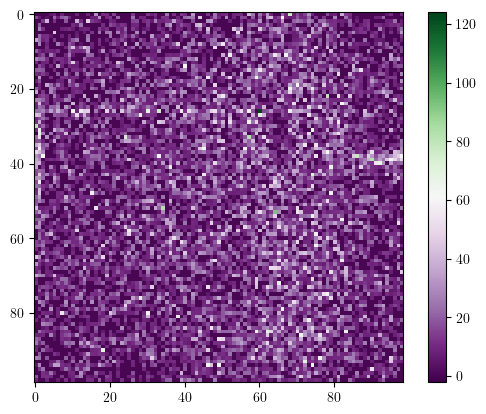

In [997]:
reload(plot_parameters)
from plot_parameters import plot_types_params

plt.close('all')

# ######### LINE #########
# xmin,xmax = -100,100
# ymin,ymax = -10,10
# plot_type = 'line'
# nlines=2
# npoints = 100
# dist_params = plot_types_params[plot_type]['distribution']['gmm'].copy()
# dist_params['nclusters'] = {'min':1, 'max':2}
# dist_params['histogram as line']['prob'] = 1.0
# xs, ys, data_params = get_gmm_data(plot_type, dist_params,
#                  xmin,xmax,
#                                    ymin=ymin,ymax=ymax,
#                     prob_same_x=0.5, nlines=nlines, npoints=npoints)
# fig, ax = plt.subplots()
# for x,y in zip(xs,ys):
#     ax.plot(x,y)
# plt.show()

# ########## SCATTER ########
# xmin,xmax = -1,1
# ymin,ymax = 0,100
# cmin,cmax = 0,1
# plot_type = 'scatter'
# npoints = 100
# dist_params = plot_types_params[plot_type]['distribution']['gmm']
# xs, ys, colors, data_params = get_gmm_data(plot_type, dist_params,
#                  xmin,xmax,ymin=ymin,ymax=ymax,cmin=cmin,cmax=cmax,
#                                            npoints=npoints)
# plt.scatter(xs,ys,c=data_params['labels'])
# plt.plot(data_params['centers'][:,0], data_params['centers'][:,1], 'x',ms=10, color='red')
# plt.colorbar()
# plt.show()



# ########## HISTOGRAM ########
# xmin,xmax = -100,100
# plot_type = 'histogram'
# npoints = 100
# dist_params = plot_types_params[plot_type]['distribution']['gmm'].copy()
# dist_params['nclusters'] = {'min':1, 'max':3}
# x, data_params = get_gmm_data(plot_type, dist_params,
#                  xmin,xmax,npoints=npoints)
# print('nclusters:', data_params['nclusters'])
# plt.hist(x)
# plt.show()


# ########## CONTOURS ########
xmin,xmax = 0,10
ymin,ymax = 0,10
cmin,cmax = 0,100
plot_type = 'contour'
nbinsx = 100
nbinsy = 100
npoints = (nbinsx,nbinsy)

dist_params = plot_types_params[plot_type]['distribution']['gmm'].copy()
dist_params['nclusters'] = {'min':100, 'max':150}
xs,ys,colors,data_params = get_gmm_data(plot_type, dist_params,
                 xmin,xmax,ymin=ymin,ymax=ymax,cmin=cmin,cmax=cmax,
                                           npoints=npoints)
print(len(xs),len(ys), colors.shape)

plt.imshow(colors)
plt.colorbar()
plt.show()

In [973]:
#np.power?

In [980]:
# nsamples1 = 100
# nclusters1 = 1

# xmin_t,xmax_t = -1,1 # true x
# xmin,xmax = 0, 10 # "y"
# std_min,std_max = 0,1

# xs = np.random.uniform(xmin_t, xmax_t, nsamples1)
# xs = np.sort(xs)
# cluster_std1 = np.random.uniform(std_min,std_max,nclusters1)

# centers_x = np.random.uniform(xmin_t,xmax_t,(nclusters1,2))
# print('centers:', centers_x)
# print('std:', cluster_std1)
# X, y_true,centers_ret = make_blobs(n_samples=nsamples1, n_features=2,
#                        cluster_std=cluster_std1, centers=centers_x,
#                       center_box=(xmin,xmax),
#                               return_centers=True)
# # collapse
# X1 = np.sum(np.abs(X), axis=1)

# #noise_level = function(noise['min'],noise['max'])
# #noise1 = np.random.normal(0,1,nsamples1)*noise_level
                            
# # multiply
# Xout = X1.flatten()#*(1+noise1.flatten())

# fig, ax = plt.subplots(1,2)
# ax[0].plot(xs,Xout)
# ax[1].scatter(X[:,0], X[:,1])

In [981]:
# X2, y_true2 = make_blobs(n_samples=100, n_features=1, centers=2)
#                       #  cluster_std=(0,5), centers=3,
#                       # center_box=(xmin,xmax),
#                       #         return_centers=True)
# plt.hist(X2)

In [982]:
#make_blobs?

In [983]:
#make_blobs?

In [984]:
#make_blobs?

In [985]:
# CONTOUR DATA
def get_contour_data(plot_params, distribution = 'random',
                     verbose=True):
    """
    plot_params : directory with plot params
    """
    data_params = {}
    nx = int(round(np.random.uniform(low=plot_params['npoints']['nx']['min'], 
                                          high=plot_params['npoints']['nx']['max'])))
    ny = int(round(np.random.uniform(low=plot_params['npoints']['ny']['min'], 
                                          high=plot_params['npoints']['ny']['max'])))
    
    xmin,xmax = plot_params['xmin'],plot_params['xmax']
    ymin,ymax = plot_params['ymin'],plot_params['ymax']

    x1 = np.random.uniform(low=xmin, high=xmax)
    x2 = np.random.uniform(low=xmin, high=xmax)
    if x1<x2:
        xmin = x1; xmax = x2
    else:
        xmin=x2; xmax=x1
    y1 = np.random.uniform(low=ymin, high=ymax)
    y2 = np.random.uniform(low=ymin, high=ymax)
    if y1<y2:
        ymin = y1; ymax = y2
    else:
        ymin=y2; ymax=y1
    c1 = np.random.uniform(low=plot_params['colors']['min'], 
                           high=plot_params['colors']['max'])
    c2 = np.random.uniform(low=plot_params['colors']['min'], 
                           high=plot_params['colors']['max'])
    if c1<c2:
        cmin = c1; cmax = c2
    else:
        cmin=c2; cmax=c1

    if distribution == 'random':
        #print(xmin,xmax)
        xs,ys,colors = get_random_data('contour',xmin,xmax,ymin,ymax,
                                  npoints=(nx,ny),
                                  zmin=cmin, zmax=cmax) 
    elif distribution == 'linear':
        xs,ys,colors, data_params = get_linear_data('contour',plot_params['distribution'][distribution],
                                                    xmin,xmax,ymin,ymax,
                                  npoints=(nx,ny))#,
                                  #zmin=cmin, zmax=cmax) 
    elif distribution == 'gmm':
        xs,ys,colors, data_params = get_gmm_data('contour',
                                                 plot_params['distribution'][distribution],
                                                    xmin,xmax,ymin,ymax,
                                  npoints=(nx,ny),
                                  zmin=cmin, zmax=cmax) 

    # do we have x/y error bars?
    hasXErr = False; hasYErr = False
    xerr,yerr = [],[] # x/y error maybe later

    # if np.random.uniform(0,1) <= plot_params['error bars']['x']['prob']: # yes
    #     hasXErr = True
    #     scale = xmax-xmin
    #     xerr = np.random.uniform(low=plot_params['error bars']['x']['size']['min']*scale, 
    #                              high=plot_params['error bars']['x']['size']['max']*scale,
    #                              size=npoints)
    # if np.random.uniform(0,1) <= plot_params['error bars']['y']['prob']: # yes
    #     hasYErr = True
    #     scale = ymax-ymin
    #     yerr = np.random.uniform(low=plot_params['error bars']['y']['size']['min']*scale, 
    #                              high=plot_params['error bars']['y']['size']['max']*scale,
    #                              size=npoints)

    #print(xerr)
    #print(yerr)
    return xs, ys, colors, xerr, yerr, data_params

In [707]:
# LINES & SCATTERS: DATA
def get_line_data(plot_params, npoints,nlines,xmin=0, xmax=1, ymin=0, ymax=1, 
                  prob_same_x=0.1,
                  xordered=True, verbose=True,
                 pick_xrange=True, pick_yrange=True,
                 distribution='random'):
    """
    ymin/ymax : can be a number of a list, if list, needs to be matched up with number of nlines
    xordered : do we want to put the x-points in a monotonic order?
    """
    data_params = {}
    if (type(ymin) not in [list, np.ndarray]) and (type(ymax) not in [list, np.ndarray]):
        pass
    elif ((type(ymin) not in [list, np.ndarray]) and (type(ymax) in [list, np.ndarray])):
        if verbose: print('type of ymin and ymax must be the same!  Will fall back on ints')
        ymax = ymax[0]
    elif ((type(ymin) in [list, np.ndarray]) and (type(ymax) not in [list, np.ndarray])):
        if verbose: print('type of ymin and ymax must be the same!  Will fall back on ints')
        ymin = ymin[0]
    elif len(ymin) != nlines or len(ymax) != nlines:
        if verbose: print('length of ymax, ymin not the same as "nlines", falling back on ints')
        ymin = ymin[0]; ymax = ymax[0]


    # print('xmin get_line_data:', xmin)
    # print('xmax get_line_data:', xmax)
    nlines = int(round(np.random.uniform(low=nlines['min'], high=nlines['max'])))
    npoints = int(round(np.random.uniform(low=npoints['min'], high=npoints['max'])))

    # pick randomly
    if pick_xrange:
        x1 = np.random.uniform(low=xmin, high=xmax)
        x2 = np.random.uniform(low=xmin, high=xmax)
        if x1<x2:
            xmin = x1; xmax = x2
        else:
            xmin=x2; xmax=x1
    if pick_yrange:
        y1 = np.random.uniform(low=ymin, high=ymax)
        y2 = np.random.uniform(low=ymin, high=ymax)
        if y1<y2:
            ymin = y1; ymax = y2
        else:
            ymin=y2; ymax=y1
    # print('xmin get_line_data 2:', xmin)
    # print('xmax get_line_data 2:', xmax)

    # into arrays
    if (type(ymin) not in [list, np.ndarray]) and (type(ymax) not in [list, np.ndarray]):
        ymin = np.repeat(ymin,nlines)
        ymax = np.repeat(ymax,nlines)

    if distribution == 'random':
        xs,ys = get_random_data('line',xmin,xmax,ymin,ymax,
                    prob_same_x=prob_same_x, 
                            nlines=nlines, npoints=npoints)
    elif distribution == 'linear':
        #print("HI IN GET LINE DATA")
        xs,ys,data_params = get_linear_data('line', plot_params['distribution'][distribution],
                                xmin,xmax,ymin,ymax,
                    prob_same_x=prob_same_x, 
                            nlines=nlines, npoints=npoints)
    elif distribution == 'gmm': # gaussian mixture model
        xs,ys,data_params = get_gmm_data('line', plot_params['distribution'][distribution],
                                xmin,xmax,ymin,ymax,
                    prob_same_x=prob_same_x, 
                            nlines=nlines, npoints=npoints)
    else:
        print("don't know how to deal with this line distribution!")
        import sys; sys.exit()

    # do we have x/y error bars?
    hasXErr = False; hasYErr = False
    xerrs,yerrs = [],[]

    # for error rate
    #scale = 
    if np.random.uniform(0,1) <= plot_params['error bars']['x']['prob']: # yes
        hasXErr = True
        scale = np.max(xmax)-np.min(xmin)
        for i in range(nlines):
            xerr = np.random.uniform(low=plot_params['error bars']['x']['size']['min']*scale, 
                                 high=plot_params['error bars']['x']['size']['max']*scale,
                                 size=npoints)
            xerrs.append(xerr)
    if np.random.uniform(0,1) <= plot_params['error bars']['y']['prob']: # yes
        hasYErr = True
        scale = np.max(ymax)-np.min(ymin)
        for i in range(nlines):
            yerr = np.random.uniform(low=plot_params['error bars']['y']['size']['min']*scale, 
                                 high=plot_params['error bars']['y']['size']['max']*scale,
                                 size=npoints)
            yerrs.append(yerr)
    
    return xs, ys, xerrs, yerrs, data_params

In [708]:
def get_scatter_data(plot_params, distribution = 'random',
                     verbose=True):
    """
    plot_params : directory with plot params
    """

    data_params = {}
    npoints = int(round(np.random.uniform(low=plot_params['npoints']['min'], 
                                          high=plot_params['npoints']['max'])))
    
    xmin,xmax = plot_params['xmin'],plot_params['xmax']
    ymin,ymax = plot_params['ymin'],plot_params['ymax']


    x1 = np.random.uniform(low=xmin, high=xmax)
    x2 = np.random.uniform(low=xmin, high=xmax)
    if x1<x2:
        xmin = x1; xmax = x2
    else:
        xmin=x2; xmax=x1
    y1 = np.random.uniform(low=ymin, high=ymax)
    y2 = np.random.uniform(low=ymin, high=ymax)
    if y1<y2:
        ymin = y1; ymax = y2
    else:
        ymin=y2; ymax=y1
    c1 = np.random.uniform(low=plot_params['colors']['min'], 
                           high=plot_params['colors']['max'])
    c2 = np.random.uniform(low=plot_params['colors']['min'], 
                           high=plot_params['colors']['max'])
    if c1<c2:
        cmin = c1; cmax = c2
    else:
        cmin=c2; cmax=c1

    if distribution == 'random':
        xs,ys,colors = get_random_data('scatter',xmin,xmax,ymin,ymax,
                                  npoints=npoints,
                                  cmin=cmin, cmax=cmax)
    elif distribution == 'linear':
        xs,ys,colors,data_params = get_linear_data('scatter', 
                                    plot_params['distribution'][distribution],
                                    xmin,xmax,ymin,ymax,
                                    cmin=cmin,cmax=cmax,
                                    npoints=npoints)
    elif distribution == 'gmm':
        xs,ys,colors,data_params = get_gmm_data('scatter', 
                                    plot_params['distribution'][distribution],
                                    xmin,xmax,ymin,ymax,
                                    cmin=cmin,cmax=cmax,
                                    npoints=npoints)
    else:
        print('no such distribution in "get_scatter_data"!')
        import sys; sys.exit()


    # do we have x/y error bars?
    hasXErr = False; hasYErr = False
    xerr,yerr = [],[]

    if np.random.uniform(0,1) <= plot_params['error bars']['x']['prob']: # yes
        hasXErr = True
        scale = xmax-xmin
        xerr = np.random.uniform(low=plot_params['error bars']['x']['size']['min']*scale, 
                                 high=plot_params['error bars']['x']['size']['max']*scale,
                                 size=npoints)
    if np.random.uniform(0,1) <= plot_params['error bars']['y']['prob']: # yes
        hasYErr = True
        scale = ymax-ymin
        yerr = np.random.uniform(low=plot_params['error bars']['y']['size']['min']*scale, 
                                 high=plot_params['error bars']['y']['size']['max']*scale,
                                 size=npoints)

    #print(xerr)
    #print(yerr)
    return xs, ys, colors, xerr, yerr, data_params

In [709]:
# HISTOGRAM PLOTS: PLOT
def get_histogram_data(plot_params, distribution = 'random',
                     verbose=True):
    """
    plot_params : plot parameters
    """

    data_params = {}
    npoints = int(round(np.random.uniform(low=plot_params['npoints']['min'], 
                                          high=plot_params['npoints']['max'])))
    
    xmin,xmax = plot_params['xmin'],plot_params['xmax']

    x1 = np.random.uniform(low=xmin, high=xmax)
    x2 = np.random.uniform(low=xmin, high=xmax)
    if x1<x2:
        xmin = x1; xmax = x2
    else:
        xmin=x2; xmax=x1

    ys = []
    if distribution == 'random':
        xs = get_random_data('histogram',xmin,xmax,
                                  npoints=npoints)
    elif distribution == 'linear':
        xs, data_params = get_linear_data('histogram',plot_params['distribution'][distribution],
                                          xmin,xmax,
                                  npoints=npoints)
    elif distribution == 'gmm':
        xs, data_params = get_gmm_data('histogram',plot_params['distribution'][distribution],
                                          xmin,xmax,
                                  npoints=npoints)
    else:
        print('no distribution in "get_histogram_data"!')
        import sys; sys.exit()
    
    # do we have x/y error bars?
    hasXErr = False; hasYErr = False
    # xerr,yerr = [],[]

    if np.random.uniform(0,1) <= plot_params['error bars']['x']['prob']: # yes
        hasXErr = True
    #     #scale = xmax-xmin
    #     scale = xs
    #     xerr = np.random.uniform(low=plot_params['error bars']['x']['size']['min'], 
    #                              high=plot_params['error bars']['x']['size']['max'],
    #                              size=npoints)*scale
        
    if np.random.uniform(0,1) < plot_params['horizontal prob']: # probability that we have a horizontal bar plot
        # flip
        ys = xs.copy()
        #yerr = xerr.copy()
        #xs = []; ys = []
        hasYErr = True
        hasXErr = False

    return xs, ys, hasXErr, hasYErr, data_params # this is different than other plots!

In [710]:
#data = get_data(plot_types_params['line'], plot_type='line')

In [711]:
##### GENERIC DATA AND PLOTS #####
def get_data(plot_params, plot_type='line', distribution='random', #npoints = 100, xmin=0, xmax=1, ymin=0, ymax=1, 
             #xordered=True, nlines=1, # line params
             verbose=True, xordered=True # general params
            ):
    if plot_type == 'line':
        xs, ys, xerrs,yerrs, data_params = get_line_data(plot_params,  
                                            plot_params['npoints'], # this bad coding, should just pass plot_params
                              plot_params['nlines'],
                              xmin=plot_params['xmin'], 
                              xmax=plot_params['xmax'], 
                              ymin=plot_params['ymin'], 
                              ymax=plot_params['ymax'], 
                              prob_same_x=plot_params['prob same x'],
                              xordered=xordered, 
                              verbose=verbose, 
                                            distribution=distribution)
        data = {'xs':xs, 'ys':ys}
        if len(xerrs) > 0:
            data['xerrs'] = xerrs
        if len(yerrs) > 0:
            data['yerrs'] = yerrs
        if data_params != {}:
            data['data params'] = data_params
        return data
    elif plot_type == 'scatter':
        xs, ys, colors_scatter,xerr,yerr, data_params = get_scatter_data(plot_params,
                                                           distribution=distribution)
        data = {'xs':xs, 'ys':ys, 'colors':colors_scatter}
        if len(xerr) > 0:
            data['xerrs'] = xerr
        if len(yerr) > 0:
            data['yerrs'] = yerr
        if data_params != {}:
            data['data params'] = data_params
        return data
    elif plot_type == 'histogram':
        xs,ys,hasXErr,hasYErr, data_params = get_histogram_data(plot_params,
                                                   distribution=distribution)
        data = {'xs':xs, 'ys':ys}
        #if len(xerr) > 0:
        if hasXErr:
            data['xerrs'] = hasXErr # different!
        #if len(yerr) > 0:
        if hasYErr:
            data['yerrs'] = hasYErr # different!
        if data_params != {}:
            data['data params'] = data_params
        return data
    elif plot_type == 'contour':
        xs, ys, color_grid,xerr,yerr, data_params = get_contour_data(plot_params,
                                                       distribution=distribution)
        data = {'xs':xs, 'ys': ys, 'colors':color_grid}
        if len(xerr) > 0:
            data['xerrs'] = xerr
        if len(yerr) > 0:
            data['yerrs'] = yerr
        if data_params != {}:
            data['data params'] = data_params
        return data
    else:
        print('not implement for this plot type!')
        import sys; sys.exit()

def make_plot(plot_params, data, ax, plot_type='line'):#, plot_style='default'):
    if plot_type == 'line':
        data_out, ax = get_line_plot(plot_params, data, ax)
        return data_out, ax
    elif plot_type == 'scatter':
        data_out, ax = get_scatter_plot(plot_params, data, ax)
        return data_out, ax
    elif plot_type == 'histogram':
        data_out, ax = get_histogram_plot(plot_params, data, ax)
        return data_out, ax
    elif plot_type == 'contour':
        data_out, ax = get_contour_plot(plot_params, data, ax)
        return data_out, ax
    else:
        print('not implement yet!')
        import sys; sys.exit()


In [712]:
# create a bunch of fake figures
reload(synthetic_fig_utils)
from synthetic_fig_utils import normalize_params_prob
reload(plot_parameters)
from plot_parameters import plot_types_params, panel_params, \
  title_params, xlabel_params, \
  ylabel_params, aspect_fig_params, dpi_params, tight_layout_params, \
  fontsizes, base


######## NORMALIZE ALL THE THINGS! ##############
plot_types_params, panel_params, \
  title_params, xlabel_params, \
  ylabel_params = normalize_params_prob(plot_types_params.copy(), panel_params, 
                                        title_params, xlabel_params, 
                                        ylabel_params)

title_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
xlabel_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
ylabel_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
plot_types_params['scatter']['color bar']['location probs'] did not add to 1! total = 0.8500000000000001
renormalizing...
now:  {'right': 0.588235294117647, 'left': 0.058823529411764705, 'top': 0.2941176470588235, 'bottom': 0.058823529411764705}
plot_types_params['contour']['color bar']['location probs'] did not add to 1! total = 0.8500000000000001
renormalizing...
now:  {'right': 0.588235294117647, 'left': 0.058823529411764705, 'top': 0.2941176470588235, 'bot

## PLOT THE THINGS

In [ ]:
datas_all = {} # for multiples
# start clear
plt.close('all')


# just in case
reload(plot_parameters)
from plot_parameters import plot_types_params, panel_params, \
  title_params, xlabel_params, \
  ylabel_params, aspect_fig_params, dpi_params, tight_layout_params, \
  fontsizes, base
# normalize
plot_types_params, panel_params, \
  title_params, xlabel_params, \
  ylabel_params = normalize_params_prob(plot_types_params.copy(), panel_params, 
                                        title_params, xlabel_params, 
                                        ylabel_params, verbose=False)

reload(plot_utils)
from plot_utils import get_contour_plot, get_histogram_plot, \
   get_line_plot, get_scatter_plot

reload(pixel_location_utils)
from pixel_location_utils import get_errorbar_pixels, get_data_pixel_locations, plot_color_bar


#for i in range(nFigs):
for i in range(1):
#for i in range(small_data_number):
    datas = {} # for each one
    print('---- ON', i+1, 'OF', small_data_number, '----')

    ######### pick things ########
    # figure
    plt.set_cmap(np.random.choice(plt.colormaps()))

    #npanels, panel_style, nrows, ncols = get_nrows_and_ncols(panel_params)
    npanels, panel_style,nrows,ncols = 1, 'horizontal', 1,1 # HACK
    plot_style = np.random.choice(plot_styles)
    if verbose: 
        print('panel style:', panel_style, 'nrows,ncols=', (nrows,ncols))
    aspect_fig = np.random.uniform(low=aspect_fig_params['min'], 
                                   high=aspect_fig_params['max'])
    dpi = int(np.random.uniform(low=dpi_params['min'], high=dpi_params['max']))
    # tight layout or not
    p = np.random.uniform(low=0, high=1.0)
    if p <= tight_layout_params[True]:
        tight_layout = True
    else:
        tight_layout = False

    # get all font stuffs
    title_fontsize, xlabel_fontsize, ylabel_fontsize, \
       xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                           csfont = get_font_info(fontsizes, font_names)
    #print("ALL IS WELL HERE 1")

    # plot types?
    success = False
    start_time = time.time()
    while not success:
        with plt.style.context(plot_style):
            if tight_layout:
                fig,axes = plt.subplots(nrows,ncols,figsize=(base*nrows, base*aspect_fig*ncols), 
                                        dpi=dpi,layout='tight')
            else:
                fig,axes = plt.subplots(nrows,ncols,figsize=(base*nrows, base*aspect_fig*ncols), 
                                        dpi=dpi)
                
            if npanels == 1:
                axes = [axes]
            else: # flatten, for now
                axes = axes.flatten()
                    
            ######### Generate plot data #########
            #print('here 1')
            
            choices = []; probs = []
            for k,v in plot_types_params.items():
                choices.append(k)
                probs.append(v['prob'])
        
            data_for_plots = []
            plot_types = []
            data_from_plots = []
            titles = []; xlabels = []; ylabels = []; cbars = []
            end_time = time.time()
            #try:
            if True:
                for iplot, ax in enumerate(axes):
                    start_time = time.time()
                    plot_type = np.random.choice(choices, p=probs)
                    print('PLOT TYPE:', plot_type)
                    # get distribution type
                    dist_params = plot_types_params[plot_type]['distribution'] 
                    choices_d = []; probs_d = []
                    for k,v in dist_params.items():
                        choices_d.append(k)
                        probs_d.append(v['prob'])

                    distribution_type = np.random.choice(choices_d, p=probs_d)
                    print('  Distribution Type:', distribution_type)
                    
                    #print('here 2')
                    data_for_plot = get_data(plot_types_params[plot_type],
                                    plot_type=plot_type,
                                            distribution=distribution_type)
                    end_time = time.time()
                
                    ######### PLOT ############
                    start_time = time.time()
                    #print('here 3')
                    data_from_plot, ax = make_plot(plot_types_params[plot_type], data_for_plot, 
                                         ax, plot_type=plot_type)#, plot_style=plot_style)
                    #import sys; sys.exit()
                    end_time = time.time()
                    #print('here 4')
    
                    # set ticksizes
                    ax.tick_params(axis='x', which='major', labelsize=xlabel_ticks_fontsize, labelfontfamily=csfont['fontname'])
                    ax.tick_params(axis='y', which='major', labelsize=ylabel_ticks_fontsize, labelfontfamily=csfont['fontname'])
    
                    start_time = time.time()
                    p = np.random.uniform(0,1)
                    if p < title_params['prob']:
                        title_words = get_titles_or_labels(popular_nouns, title_params['capitalize'],
                                                 title_params['equation'], inlines,
                                                 nwords=np.random.randint(low=title_params['n words']['min'],
                                                                          high=title_params['n words']['max']+1))
                        title = ax.set_title(title_words, fontsize = title_fontsize, **csfont)
                    else:
                        title = ''
                        
                    xlabel_words = get_titles_or_labels(popular_nouns, xlabel_params['capitalize'],
                                                 xlabel_params['equation'], inlines,
                                                 nwords=np.random.randint(low=xlabel_params['n words']['min'],
                                                                          high=xlabel_params['n words']['max']+1))
                    xlabel = ax.set_xlabel(xlabel_words, fontsize=xlabel_fontsize, **csfont)
                    ylabel_words = get_titles_or_labels(popular_nouns, ylabel_params['capitalize'],
                                                 ylabel_params['equation'], inlines,
                                                 nwords=np.random.randint(low=ylabel_params['n words']['min'],
                                                                          high=ylabel_params['n words']['max']+1))
                    ylabel = ax.set_ylabel(ylabel_words, fontsize=ylabel_fontsize, **csfont)
                    end_time = time.time()
            
                    # save
                    data_for_plots.append(data_for_plot)
                    plot_types.append(plot_type)
                    data_from_plots.append(data_from_plot)
                    titles.append(title)
                    xlabels.append(xlabel)
                    ylabels.append(ylabel)
    
                    if plot_type == 'scatter': # or plot_type == 'contour':
                        if 'color bar' in data_from_plot:
                            side = data_from_plot['color bar params']['side']
                            if side == 'top' or side == 'bottom':
                                orientation = 'horizontal'
                            else:
                                orientation = 'vertical'
    
                            cbar = fig.colorbar(data_from_plot['data'], 
                                         cax=data_from_plot['color bar'], 
                                         orientation=orientation)
                            cbars.append(cbar)

                    if plot_type == 'contour':
                        if 'color bar' in data_from_plot:
                            side = data_from_plot['color bar params']['side']
                            if side == 'top' or side == 'bottom':
                                orientation = 'horizontal'
                            else:
                                orientation = 'vertical'
                    
                            if 'image' in data_from_plot['data']: # select correct colorbar to use
                                datac = data_from_plot['data']['image']
                            else:
                                datac = data_from_plot['data']['contour']
                                            
                            cbar = fig.colorbar(datac, 
                                         cax=data_from_plot['color bar'], 
                                         orientation=orientation)
                            cbars.append(cbar)

    
                if not save_smalls:
                    fig.savefig(fake_figs_dir + 'Picture' + str(i+1) + '.png', dpi=dpi)
                    print('saved:', fake_figs_dir + 'Picture' + str(i+1) + '.png')
                else:
                    fig.savefig(save_small_dir + 'Picture' + str(i+1) + '.png', dpi=dpi)
                    print('saved:', save_small_dir + 'Picture' + str(i+1) + '.png')
                    
                success = True
            #except Exception as e:
            else:
                plt.close(fig)
                print('issue with plotting, trying again')
                print(e)
                if 'unknown color specifier' in str(e):
                    print(e)
                    import sys; sys.exit()
                if 'At least one value in the dash list must be positive' in str(e):
                    print(e)
                    print(data_from_plots)
    
    
    ####### end of plotting ############
    # try the whole thing again
    width, height = fig.canvas.get_width_height()
    # save data
    datas = {}
    # figure datas
    datas['figure'] = {'dpi':dpi, 'base':base, 'aspect ratio': aspect_fig, 
                          'nrows':nrows, 'ncols':ncols, 
                         'plot style':plot_style, 
                         'title fontsize':title_fontsize, 
                         'xlabel fontsize':xlabel_fontsize,
                         'ylabel fontsize':ylabel_fontsize}
    
    # now, get data things
    for iplot, ax in enumerate(axes):
        ###### get data from plot ######
        data_from_plot = data_from_plots[iplot]
        data_for_plot = data_for_plots[iplot]
        plot_type = plot_types[iplot]
        title = titles[iplot]
        xlabel = xlabels[iplot]
        ylabel = ylabels[iplot]
    
        data_pixels = get_data_pixel_locations(data_from_plot, plot_type, ax, width, height)
    
        # bounding box of square
        bbox = ax.get_position() # Bbox(x0, y0, x1, y1)
        xpix1 = np.array([bbox.x0,bbox.x1])
        ypix1 = np.array([bbox.y0,bbox.y1])
        xpix1 *= width
        ypix1 *= height
        
        # x-tick locations
        xticks = get_ticks(ax.get_xticklabels(), ax.get_xticklines())
    
        # y-tick locations
        yticks = get_ticks(ax.get_yticklabels(), ax.get_yticklines())
        
        # for colorbars
        colorbar_ticks = []
        if 'color bar' in data_from_plots[iplot]:
            colorbar = data_from_plots[iplot]['color bar']
            if data_from_plots[iplot]['color bar params']['side'] == 'left' \
               or data_from_plots[iplot]['color bar params']['side'] == 'right':
                ticks = colorbar.get_yticklabels()
                tick_locs = colorbar.get_yticklines(minor=False)
            else:
                ticks = colorbar.get_xticklabels()
                tick_locs = colorbar.get_xticklines(minor=False)
            colorbar_ticks = get_ticks(ticks, tick_locs)

        # title
        # Get the bounding box of the title in display space
        if title != '':
            title_bbox = title.get_window_extent()
            title_words = title.get_text()
        else:
            title_bbox = -1
            title_words = ''
    
        # xlabel
        xlabel_bbox = xlabel.get_window_extent()
        xlabel_words = xlabel.get_text()
        # ylabel
        ylabel_bbox = ylabel.get_window_extent()
        ylabel_words = ylabel.get_text()
    
    
        ########## save data ##############

        # line plot 
        plot_name = 'plot' + str(iplot) 
        datas[plot_name] = {}
        # line plot type
        datas[plot_name]['type'] = plot_type # tag for kind of plot
        datas[plot_name]['distribution'] = distribution_type
        datas[plot_name]['data'] = data_for_plot
        datas[plot_name]['data pixels'] = data_pixels
        datas[plot_name]['data from plot'] = json.loads(json.dumps(data_from_plot, cls=NumpyEncoder))
        if (plot_type == 'scatter' or plot_type == 'contour') and 'color bar' in data_from_plots[iplot]:
            print('yes indeed')
            w = data_from_plots[iplot]['color bar'].get_window_extent()
            datas[plot_name]['color bar'] = {'xmin':w.x0,'ymin':w.y0,
                                             'xmax':w.x1,'ymax':w.y1, 
                                             'params':data_from_plot['color bar params']}
        # if plot_type == 'contour':
        #     print('yes dood')
        #     if 'image' in data_from_plots[iplot]['data']:
        #         print('yes image')
        #         if 'color bar' in data_from_plots[iplot]['data']['image']:
        #             w = data_from_plots[iplot]['data']['image']['color bar'].get_window_extent()
        #             datas[plot_name]['color bar'] = {'xmin':w.x0,'ymin':w.y0,
        #                                              'xmax':w.x1,'ymax':w.y1, 
        #                                              'params':data_from_plot['color bar params'],
        #                                             'color bar with':'image'}
        #     if 'contour' in data_from_plots[iplot]['data']:
        #         print('yes contour')
        #         if 'color bar' in data_from_plots[iplot]['data']['contour']:
        #             w = data_from_plots[iplot]['data']['contour']['color bar'].get_window_extent()
        #             datas[plot_name]['color bar'] = {'xmin':w.x0,'ymin':w.y0,
        #                                              'xmax':w.x1,'ymax':w.y1, 
        #                                              'params':data_from_plot['color bar params'],
        #                                             'color bar with':'contour'}
        xtmp = []
        for xt in xticks:
            l = {'data':xt[0], 'xmin': xt[1], 
                 'ymin': xt[2], 
                 'xmax':xt[3], 'ymax':xt[4],
                 'tx':xt[5], 'ty':xt[6]}
            xtmp.append(l)
        datas[plot_name]['xticks'] = xtmp.copy()
        # 
        xtmp = []
        for xt in yticks:
            l = {'data':xt[0], 'xmin': xt[1], 
                 'ymin': xt[2], 
                 'xmax':xt[3], 'ymax':xt[4], 
                'tx':xt[5], 'ty':xt[6]}
            xtmp.append(l)
        datas[plot_name]['yticks'] = xtmp.copy()
        if len(colorbar_ticks) > 0:
            xtmp = []
            for xt in colorbar_ticks:
                l = {'data':xt[0], 'xmin': xt[1], 
                     'ymin': xt[2], 
                     'xmax':xt[3], 'ymax':xt[4], 
                    'tx':xt[5], 'ty':xt[6]}
                xtmp.append(l)
            datas[plot_name]['color bar ticks'] = xtmp.copy()
            
        # axis box
        datas[plot_name]['square'] = {'xmin':xpix1[0], 'ymin':ypix1[0], 
                                         'xmax':xpix1[1], 'ymax':ypix1[1]}
        # title
        if title_bbox != -1:
            datas[plot_name]['title'] = {'xmin':title_bbox.x0, 'ymin':title_bbox.y0, 
                                            'xmax':title_bbox.x1, 'ymax':title_bbox.y1,
                                           'words':title_words}
        else:
            pass
        datas[plot_name]['xlabel'] = {'xmin':xlabel_bbox.x0, 'ymin':xlabel_bbox.y0, 
                                        'xmax':xlabel_bbox.x1, 'ymax':xlabel_bbox.y1,
                                       'words':xlabel_words}
        datas[plot_name]['ylabel'] = {'xmin':ylabel_bbox.x0, 'ymin':ylabel_bbox.y0, 
                                        'xmax':ylabel_bbox.x1, 'ymax':ylabel_bbox.y1,
                                       'words':ylabel_words}

    # save this for small datas
    if save_smalls:
        dumped = json.dumps(datas, cls=NumpyEncoder)
        file_path = save_small_dir + 'Picture' + str(i+1) + '.json'
        with open(file_path, 'w') as f:
            json.dump(dumped, f)
            
    # for full thing
    datas_all[i] = datas.copy()
    plt.close(fig)
print('DONE!')

---- ON 1 OF 10 ----
panel style: horizontal nrows,ncols= (1, 1)
PLOT TYPE: contour
  Distribution Type: gmm


In [ ]:
#np.random.random?

In [ ]:
print('DONE DONE!')

In [ ]:
#datas['plot0']['color bar']

In [ ]:
reload(pixel_location_utils)
from pixel_location_utils import plot_color_bar

In [ ]:
%matplotlib widget
#%matplotlib inline
plt.close('all')

csize = 5

ifig = 0 # which one to plot?

if not save_smalls:
    img = np.array(Image.open(fake_figs_dir+'Picture'+str(ifig+1)+'.png').convert('RGB'))
    datas_plot = datas_all[ifig].copy()
else:
    img = np.array(Image.open(save_small_dir+'Picture'+str(ifig+1)+'.png').convert('RGB'))
    with open(save_small_dir+'Picture'+str(ifig+1)+'.json','r') as f:
        datas_plot1 = json.load(f) # weirdness
        datas_plot = json.loads(datas_plot1)
imgplot = img.copy()


iplot_count = 0
for p,v in datas_plot.items():
    iplot_count += 1
    if 'plot' in p: # not figure stuffs... just yet
        # square
        d = v['square']
        xmin,ymin = int(d['xmin']),int(img.shape[0]-d['ymin'])
        xmax,ymax = int(d['xmax']),int(img.shape[0]-d['ymax'])
        cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
        # title bounding box
        if 'title' in v: # has a title?
            d = v['title']
            xmin,ymin = int(d['xmin']),int(img.shape[0]-d['ymin'])
            xmax,ymax = int(d['xmax']),int(img.shape[0]-d['ymax'])
            cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
        # xlabel bounding box
        d = v['xlabel']
        xmin,ymin = int(d['xmin']),int(img.shape[0]-d['ymin'])
        xmax,ymax = int(d['xmax']),int(img.shape[0]-d['ymax'])
        cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
        # ylabel bounding box
        d = v['ylabel']
        xmin,ymin = int(d['xmin']),int(img.shape[0]-d['ymin'])
        xmax,ymax = int(d['xmax']),int(img.shape[0]-d['ymax'])
        cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)

        #print('PLOT:', p)
        if v['type'] == 'line':
            xs = v['data pixels']['xs']
            ys = v['data pixels']['ys']
            for xx,yy in zip(xs,ys):
                for x,y in zip(xx,yy):
                    cv.circle(imgplot, (int(x), int(y)), csize, (255,0,0), -1)
        elif v['type'] == 'scatter':
            xs = v['data pixels']['xs']
            ys = v['data pixels']['ys']
            for x,y in zip(xs,ys):
                cv.circle(imgplot, (int(x), int(y)), csize, (255,0,0), -1)
            # colorbar
            if 'color bar' in v:
                imgplot = plot_color_bar(v,img,imgplot)
        elif v['type'] == 'histogram':
            # middle of bar
            xs = np.array(v['data pixels']['xs'])
            ys = np.array(v['data pixels']['ys'])
            for x,y in zip(xs,ys): # middle
                cv.circle(imgplot, (int(x), int(y)), csize, (255,0,0), -1)
            # right
            xsr = np.array(v['data pixels']['xs_right'])
            ysr = np.array(v['data pixels']['ys_right'])
            for x,y in zip(xsr,ysr): # right
                cv.circle(imgplot, (int(x), int(y)), csize, (0,0,255), -1)
            # left
            xsl = np.array(v['data pixels']['xs_left'])
            ysl = np.array(v['data pixels']['ys_left'])
            for x,y in zip(xsl,ysl): # left
                cv.circle(imgplot, (int(x), int(y)), csize, (255,0,125), -1)
        elif v['type'] == 'contour':
            #xs = np.array
            #xs = []; ys = []
            #if 'image' in v['data pixels']:
            if v['data pixels']['image'] != {}:
                xs = v['data pixels']['image']['xsc']
                ys = v['data pixels']['image']['ysc']
                #print('image')
                #print(xs[:10], ys[:10])
                for x,y in zip(xs,ys):
                    #print(x,y)
                    cv.circle(imgplot, (int(x), int(y)), csize, (0,255,0), -1)
            #if 'contour' in v['data pixels']:
            if v['data pixels']['contour'] != {}:
                xs = v['data pixels']['contour']['xs']
                ys = v['data pixels']['contour']['ys']
                #print('contour')
                #print(xs[:10], ys[:10])
                for x,y in zip(xs,ys):
                    #print(x,y)
                    cv.circle(imgplot, (int(x), int(y)), csize, (0,255,255), -1)
            if 'color bar' in v:
                #print('ding')
                imgplot = plot_color_bar(v,img,imgplot)
            
        else:
            print('no idea how to deal!')
            import sys; sys.exit()

        # these are things for every plot
        for d in v['xticks']: # draw x-ticks
            xmin,ymin,xmax,ymax = int(d['xmin']),int(img.shape[0]-d['ymin']),int(d['xmax']),int(img.shape[0]-d['ymax'])
            if d['tx']>=v['square']['xmin'] and d['tx']<=v['square']['xmax']:
                cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
            # also ticks
            if d['tx']>=v['square']['xmin'] and d['tx']<=v['square']['xmax']:
                cv.circle(imgplot, (int(d['tx']), int(img.shape[0]-d['ty'])), 10, (255,0,0), -1)
        for d in v['yticks']: # draw y-ticks
            xmin,ymin,xmax,ymax = int(d['xmin']),int(img.shape[0]-d['ymin']),int(d['xmax']),int(img.shape[0]-d['ymax'])
            if d['ty']>=v['square']['ymin'] and d['ty']<=v['square']['ymax']:
                cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
            if d['ty']>=v['square']['ymin'] and d['ty']<=v['square']['ymax']:
                cv.circle(imgplot, (int(d['tx']), int(img.shape[0]-d['ty'])), 10, (255,0,0), -1)
        if v['type'] == 'line':
            if 'x error bars' in v['data pixels']:
                for il,l in enumerate(v['data pixels']['x error bars']):
                    for ie,(xmin,ymin,xmax,ymax) in enumerate(l):
                        xmin,ymin = int(round(xmin)),int(round(img.shape[0]-ymin))
                        xmax,ymax = int(round(xmax)),int(round(img.shape[0]-ymax))
                        # only take parts within square
                        xmin = max(xmin,int(round(v['square']['xmin'])))
                        xmax = min(xmax,int(round(v['square']['xmax'])))
                        ymin = max(ymin,int(round(img.shape[0]-v['square']['ymax'])))
                        ymax = min(ymax,int(round(img.shape[0]-v['square']['ymin'])))
                        cv.line(imgplot, (xmin,ymin),(xmax,ymax), (255,0,0), 2)
            if 'y error bars' in v['data pixels']:
                for l in v['data pixels']['y error bars']:
                    for xmin,ymin,xmax,ymax in l:
                        xmin,ymin = int(round(xmin)),int(round(img.shape[0]-ymin))
                        xmax,ymax = int(round(xmax)),int(round(img.shape[0]-ymax))
                        # only take parts within square
                        xmin = max(xmin,int(round(v['square']['xmin'])))
                        xmax = min(xmax,int(round(v['square']['xmax'])))
                        ymin = max(ymin,int(round(img.shape[0]-v['square']['ymax'])))
                        ymax = min(ymax,int(round(img.shape[0]-v['square']['ymin'])))
                        cv.line(imgplot, (xmin,ymin),(xmax,ymax), (255,0,0), 2)
        elif v['type'] == 'scatter' or v['type'] == 'histogram':
            if 'x error bars' in v['data pixels']:
                for xmin,ymin,xmax,ymax in v['data pixels']['x error bars']:
                    xmin,ymin = int(round(xmin)),int(round(img.shape[0]-ymin))
                    xmax,ymax = int(round(xmax)),int(round(img.shape[0]-ymax))
                    # only take parts within square
                    xmin = max(xmin,int(round(v['square']['xmin'])))
                    xmax = min(xmax,int(round(v['square']['xmax'])))
                    ymin = max(ymin,int(round(img.shape[0]-v['square']['ymax'])))
                    ymax = min(ymax,int(round(img.shape[0]-v['square']['ymin'])))
                    cv.line(imgplot, (xmin,ymin),(xmax,ymax), (255,0,0), 2)
            if 'y error bars' in v['data pixels']:
                for xmin,ymin,xmax,ymax in v['data pixels']['y error bars']:
                    #print(ymin,ymax)
                    xmin,ymin = int(round(xmin)),int(round(img.shape[0]-ymin))
                    xmax,ymax = int(round(xmax)),int(round(img.shape[0]-ymax))
                    xmin = max(xmin,int(round(v['square']['xmin'])))
                    xmax = min(xmax,int(round(v['square']['xmax'])))
                    ymin = max(ymin,int(round(img.shape[0]-v['square']['ymax'])))
                    ymax = min(ymax,int(round(img.shape[0]-v['square']['ymin'])))
                    cv.line(imgplot, (xmin,ymin),(xmax,ymax), (255,0,0), 2)
                    #print('')

#fig2,ax2 = plt.subplots(1,2,figsize=(20,20), sharex=True, sharey=True) # inline
fig2,ax2 = plt.subplots(1,2,figsize=(15,10), sharex=True, sharey=True) # widget
ax2[0].imshow(img)
ax2[1].imshow(imgplot)
plt.show()

In [ ]:
#v['data']['data params']

In [213]:
v['data from plot']

{'data': {'image': 'non serializable entry'},
 'color bar': 'non serializable entry',
 'color bar params': {'side': 'top',
  'pad': 0.020761467752320063,
  'size': '12%',
  'axis side': 'top'}}

In [31]:
ifig = 7 # which one to plot?

if not save_smalls:
    img = np.array(Image.open(fake_figs_dir+'Picture'+str(ifig+1)+'.png').convert('RGB'))
    datas_plot = datas_all[ifig].copy()
else:
    img = np.array(Image.open(save_small_dir+'Picture'+str(ifig+1)+'.png').convert('RGB'))
    with open(save_small_dir+'Picture'+str(ifig+1)+'.json','r') as f:
        datas_plot1 = json.load(f) # weirdness
        datas_plot = json.loads(datas_plot1)

In [32]:
datas_plot['plot0'].keys()

dict_keys(['type', 'data', 'data pixels', 'data from plot', 'xticks', 'yticks', 'square', 'xlabel', 'ylabel'])

In [33]:
datas_plot['plot0']['data from plot']

{'data': ['non serializable entry',
  'non serializable entry',
  'non serializable entry'],
 'plot params': {'linethick': [2.614879465821844,
   1.4730744887847127,
   1.1188482698177826],
  'linestyles': [[0, [3, 10, 1, 10]], 'solid', 'dotted'],
  'markers': ['3', 'P', '+'],
  'marker size': [1, 1, 1]},
 'y error bars': [['non serializable entry'],
  ['non serializable entry'],
  ['non serializable entry']]}